In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # For plotting theoretical distributions

# Linear Congruential Generator (LCG) Class
class LCG:
    def __init__(self, seed, a=1664525, c=1013904223, m=2**32):
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m
        self.current = seed

    def random(self):
        """
        Generates a pseudo-random number between 0 and 1.
        Every time you call lcg.random(), the current value is updated according to the linear congruential formula: 
        X_{n+1} = (a * X_n + c) mod m
        """
        self.current = (self.a * self.current + self.c) % self.m
        return self.current / self.m  # Normalize to [0, 1)


In [23]:

# Helper Function for Scaling
def scale_to_range(value, min_value, max_value, a, b):
    """
    Scales a value from [min_value, max_value] to [a, b].
    """
    return a + (value - min_value) * (b - a) / (max_value - min_value)

# Box-Muller Transform for Normal Distribution
def box_muller(lcg):
    u1 = lcg.random()
    u2 = lcg.random()
    z1 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
    z2 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2.0 * math.pi * u2)
    return z1, z2

#### Continuous Distributions
def generate_normal_demand(lcg, mu=0, sigma=1, a=0, b=1):
    z1, _ = box_muller(lcg)
    raw_value = mu + sigma * z1
    # Scale to [a, b] assuming 99.7% of data lies within ±3σ
    min_value = mu - 3 * sigma
    max_value = mu + 3 * sigma
    return max(min(scale_to_range(raw_value, min_value, max_value, a, b), b), a) # to be sure that the value is within the range [a, b]

def generate_uniform_demand(lcg, a=0, b=1):
    u = lcg.random()
    return a + (b - a) * u

def generate_exponential_demand(lcg, lam=1, a=0, b=1):
    u = lcg.random()
    raw_value = -math.log(u) / lam
    # Scale to [a, b] assuming raw_value is within [0, 3/lam]
    min_value = 0
    max_value = 3 / lam
    return max(min(scale_to_range(raw_value, min_value, max_value, a, b), b), a)

def generate_lognormal_demand(lcg, mu=0, sigma=1, a=0, b=1):
    z1, _ = box_muller(lcg)
    raw_value = math.exp(mu + sigma * z1)
    # Scale to [a, b] assuming a reasonable range of [0, 3σ]
    min_value = math.exp(mu - 3 * sigma)
    max_value = math.exp(mu + 3 * sigma)
    return max(min(scale_to_range(raw_value, min_value, max_value, a, b), b), a)

#===NEW===#
def generate_triangular_demand(lcg, a=0, c=0.5, b=1):
    u = lcg.random()
    if u < (c - a) / (b - a):
        return a + math.sqrt(u * (b - a) * (c - a))
    else:
        return b - math.sqrt((1 - u) * (b - a) * (b - c))
#===NEW===#
def generate_beta_demand(lcg, alpha=2, beta=5, a=0, b=1):
    """
    Generates a random variable following the Beta distribution using LCG for randomness.
    
    Parameters:
    - lcg: An instance of the LCG class for generating random numbers.
    - alpha: Fixed shape parameter for the first Gamma distribution (default = 2).
    - beta: Fixed shape parameter for the second Gamma distribution (default = 5).
    - a: Lower bound of the Beta distribution (default = 0). This scales the random variable to the desired range.
    - b: Upper bound of the Beta distribution (default = 1). This scales the random variable to the desired range.
    
    Returns:
    - A beta-distributed random variable in the range [0, 1].
    """
    def generate_gamma(lcg, shape):
        """
        Generates a Gamma-distributed random variable using the acceptance-rejection method.
        """
        if shape < 1:
            # Use Johnk's method for shape < 1
            while True:
                u = lcg.random()
                v = lcg.random()
                x = u ** (1 / shape)
                y = v ** (1 / (1 - shape))
                if x + y <= 1:
                    return -math.log(lcg.random()) * x / (x + y)
        else:
            # Use Marsaglia and Tsang's method for shape >= 1
            d = shape - 1 / 3
            c = 1 / math.sqrt(9 * d)
            while True:
                u = lcg.random()
                v = lcg.random()
                z = (2 * u - 1) * c
                x = d * ((1 + z) ** 3)
                if x > 0 and math.log(v) < 0.5 * z ** 2 + d - d * math.log(x):
                    return x

    # Generate two independent gamma random variables
    x = generate_gamma(lcg, alpha)
    y = generate_gamma(lcg, beta)
    raw_value = x / (x + y)

    return scale_to_range(raw_value, 0, 1, a, b)

#===NEW===#
def generate_weibull_demand(lcg, lam=1, k=1.5, a=0, b=1):
    u = lcg.random()
    raw_value = lam * (-math.log(1 - u))**(1 / k)
    # Scale to [a, b] assuming raw_value is within [0, 3λ]
    min_value = 0
    max_value = 3 * lam
    return max(min(scale_to_range(raw_value, min_value, max_value, a, b), b), a)

#### Discrete Distributions
def generate_poisson_demand(lcg, lam=1, a=0, b=1):
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        u = lcg.random()
        p *= u
    return a + (k - 1) % (b - a + 1)  # Map to range [a, b]

def generate_binomial_demand(lcg, n=10, p=0.5, a=0, b=1):
    successes = 0
    for _ in range(n):
        if lcg.random() < p:
            successes += 1
    return a + successes % (b - a + 1)  # Map to range [a, b]

#===NEW===#
def generate_bernoulli_demand(lcg, p=0.5, a=0, b=1):
    x = 1 if lcg.random() < p else 0
    return a if x == 0 else b

#===NEW===#
def generate_geometric_demand(lcg, p=0.5, a=0, b=1):
    u = lcg.random()
    raw_value = math.ceil(math.log(1 - u) / math.log(1 - p))
    return a + raw_value % (b - a + 1)  # Map to range [a, b]

#===NEW===#
def generate_negative_binomial_demand(lcg, r=10, p=0.5, a=0, b=1):
    successes = 0
    trials = 0
    while successes < r:
        if lcg.random() < p:
            successes += 1
        trials += 1
    return a + trials % (b - a + 1)  # Map to range [a, b]


In [27]:
# Function to simulate demand for any distribution
def simulate_demand(lcg, iterations, distribution='normal', **kwargs):
    demands = []
    for _ in range(iterations):
        if distribution == 'normal':
            demand = generate_normal_demand(lcg,mu=kwargs.get('mu', 0),sigma=kwargs.get('sigma', 1),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'uniform':
            demand = generate_uniform_demand(lcg,a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'exponential':
            demand = generate_exponential_demand(lcg,lam=kwargs.get('lam', 1),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'poisson':
            demand = generate_poisson_demand(lcg,lam=kwargs.get('lam', 1),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'binomial':
            demand = generate_binomial_demand(lcg,n=kwargs.get('n', 10),p=kwargs.get('p', 0.5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'lognormal':
            demand = generate_lognormal_demand(lcg,mu=kwargs.get('mu', 0),sigma=kwargs.get('sigma', 1),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'bernoulli':
            demand = generate_bernoulli_demand(lcg,p=kwargs.get('p', 0.5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'geometric':
            demand = generate_geometric_demand(lcg,p=kwargs.get('p', 0.5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'negative_binomial':
            demand = generate_negative_binomial_demand(lcg,r=kwargs.get('r', 10),p=kwargs.get('p', 0.5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'triangular':
            demand = generate_triangular_demand(lcg,a=kwargs.get('a', 0),c=kwargs.get('c', 0.5),b=kwargs.get('b', 1))
        elif distribution == 'beta':
            demand = generate_beta_demand(lcg,alpha=kwargs.get('alpha', 2), beta=kwargs.get('beta', 5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        elif distribution == 'weibull':
            demand = generate_weibull_demand(lcg,lam=kwargs.get('lam', 1),k=kwargs.get('k', 1.5),a=kwargs.get('a', 0),b=kwargs.get('b', 1))
        else:
            available_distributions = [
                'normal', 'uniform', 'exponential', 'poisson', 'binomial', 
                'lognormal', 'bernoulli', 'geometric', 'negative_binomial', 
                'triangular', 'beta', 'weibull'
            ]
            raise ValueError(f"Unknown distribution: {distribution}. Available options: {available_distributions}")
        demands.append(demand)
    return np.array(demands)

# Plot demand and theoretical distribution
def plot_demand_distribution(demands, distribution, **kwargs):
    plt.hist(demands, bins=50, density=True, alpha=0.6, color='g', label='Simulated Demand')
    
    # Define x-axis range
    x = np.linspace(min(demands), max(demands), 1000)
    
    # Continuous distributions
    if distribution == 'normal':
        mu, sigma = kwargs.get('mu', 0), kwargs.get('sigma', 1)
        a, b = kwargs.get('a', mu - 3 * sigma), kwargs.get('b', mu + 3 * sigma)
        scaled_pdf = stats.norm.pdf(x, mu, sigma) / (b - a)
        plt.plot(x, scaled_pdf, 'r-', lw=2, label='Normal PDF')
    elif distribution == 'uniform':
        a, b = kwargs.get('a', 0), kwargs.get('b', 1)
        plt.plot(x, stats.uniform.pdf(x, loc=a, scale=b - a), 'r-', lw=2, label='Uniform PDF')
    elif distribution == 'exponential':
        lam = kwargs.get('lam', 1)
        a, b = kwargs.get('a', 0), kwargs.get('b', 3 / lam)
        scaled_pdf = stats.expon.pdf(x, scale=1 / lam) / (b - a)
        plt.plot(x, scaled_pdf, 'r-', lw=2, label='Exponential PDF')
    elif distribution == 'lognormal':
        mu, sigma = kwargs.get('mu', 0), kwargs.get('sigma', 1)
        a, b = kwargs.get('a', math.exp(mu - 3 * sigma)), kwargs.get('b', math.exp(mu + 3 * sigma))
        scaled_pdf = stats.lognorm.pdf(x, sigma, scale=np.exp(mu)) / (b - a)
        plt.plot(x, scaled_pdf, 'r-', lw=2, label='Lognormal PDF')
    elif distribution == 'triangular':
        a, c, b = kwargs.get('a', 0), kwargs.get('c', 0.5), kwargs.get('b', 1)
        plt.plot(x, stats.triang.pdf(x, (c - a) / (b - a), loc=a, scale=b - a), 'r-', lw=2, label='Triangular PDF')
    elif distribution == 'beta':
        alpha, beta, a, b = kwargs.get('alpha', 2), kwargs.get('beta', 5), kwargs.get('a', 0), kwargs.get('b', 1)
        scaled_pdf = stats.beta.pdf((x - a) / (b - a), alpha, beta) / (b - a)
        plt.plot(x, scaled_pdf, 'r-', lw=2, label='Beta PDF')
    elif distribution == 'weibull':
        lam, k = kwargs.get('lam', 1), kwargs.get('k', 1.5)
        a, b = kwargs.get('a', 0), kwargs.get('b', 3 * lam)
        scaled_pdf = stats.weibull_min.pdf(x, k, scale=lam) / (b - a)
        plt.plot(x, scaled_pdf, 'r-', lw=2, label='Weibull PDF')

    # Discrete distributions
    elif distribution == 'poisson':
        lam = kwargs.get('lam', 1)
        a, b = kwargs.get('a', 0), kwargs.get('b', max(demands))
        k = np.arange(min(demands), max(demands) + 1)
        scaled_k = a + (k - min(k)) % (b - a + 1)  # Scale k to [a, b]
        pmf = stats.poisson.pmf(k, lam)
        plt.bar(scaled_k, pmf, alpha=0.75, label='Poisson PMF', color='b')
    elif distribution == 'geometric':
        p, a, b = kwargs.get('p', 0.5), kwargs.get('a', 0), kwargs.get('b', max(demands))
        k = np.arange(min(demands), max(demands) + 1)
        scaled_k = a + (k - min(k)) % (b - a + 1)
        pmf = stats.geom.pmf(k, p)
        plt.bar(scaled_k, pmf, alpha=0.75, label='Geometric PMF', color='b')
    elif distribution == 'negative_binomial':
        r, p = kwargs.get('r', 10), kwargs.get('p', 0.5)
        a, b = kwargs.get('a', 0), kwargs.get('b', max(demands))
        k = np.arange(min(demands), max(demands) + 1)
        scaled_k = a + (k - min(k)) % (b - a + 1)
        pmf = stats.nbinom.pmf(k, r, p)
        plt.bar(scaled_k, pmf, alpha=0.75, label='Negative Binomial PMF', color='b')
    elif distribution == 'bernoulli':
        p, a, b = kwargs.get('p', 0.5), kwargs.get('a', 0), kwargs.get('b', 1)
        k = np.array([0, 1])
        scaled_k = a + k * (b - a)
        pmf = stats.bernoulli.pmf(k, p)
        plt.bar(scaled_k, pmf, alpha=0.75, label='Bernoulli PMF', color='b')
    elif distribution == 'binomial':
        n, p = kwargs.get('n', 10), kwargs.get('p', 0.5)
        a, b = kwargs.get('a', 0), kwargs.get('b', max(demands))
        k = np.arange(0, n + 1)
        scaled_k = a + (k - min(k)) % (b - a + 1)
        pmf = stats.binom.pmf(k, n, p)
        plt.bar(scaled_k, pmf, alpha=0.75, label='Binomial PMF', color='b')

    # Titles, labels, and legend
    plt.title(f"Demand Distribution: {distribution.capitalize()}")
    plt.xlabel('Demand')
    plt.ylabel('Density' if distribution in ['normal', 'uniform', 'exponential', 'lognormal', 'weibull', 'triangular', 'beta'] else 'Probability')
    plt.legend()
    plt.grid(True)
    plt.show()



In [28]:
""" old simulate_newsvendor with no holding cost
def simulate_newsvendor(order_quantity, selling_price, unit_cost, salvage_value, demands):
    # Input validation
    if selling_price <= unit_cost:
        raise ValueError("Selling price must be greater than unit cost.")
    if salvage_value > unit_cost:
        raise ValueError("Salvage value cannot exceed the unit cost.")
    if order_quantity < 0:
        raise ValueError("Order quantity cannot be negative.")

    # Calculate profits for all demands
    profits = []
    for demand in demands:
        if demand <= order_quantity:
            profit = selling_price * demand - unit_cost * order_quantity + salvage_value * (order_quantity - demand)
        else:
            profit = selling_price * order_quantity - unit_cost * order_quantity  # Stockout scenario
        profits.append(profit)
    profits = np.array(profits)
    
    # Return the average profit
    return np.mean(profits)
"""
#===NEW===#
""" new simulate_newsvendor with generalized formula to account for salvage value and holding cost"""
def simulate_newsvendor(order_quantity, selling_price, unit_cost, demands, salvage_value, holding_cost):

    # Input validation
    if selling_price <= unit_cost:
        raise ValueError("Selling price must be greater than unit cost.")
    if salvage_value < 0 or holding_cost < 0:
        raise ValueError("Salvage value and holding cost must be non-negative.")
    if order_quantity < 0:
        raise ValueError("Order quantity cannot be negative.")
    
    profits = []
    for demand in demands:
        if demand <= order_quantity:
            # Excess inventory case
            profit = (
                selling_price * demand
                - unit_cost * order_quantity
                + salvage_value * (order_quantity - demand)
                - holding_cost * (order_quantity - demand)
            )
        else:
            # Stockout case
            profit = selling_price * order_quantity - unit_cost * order_quantity
        
        profits.append(profit)
    
    # Return the average profit
    return np.mean(profits)



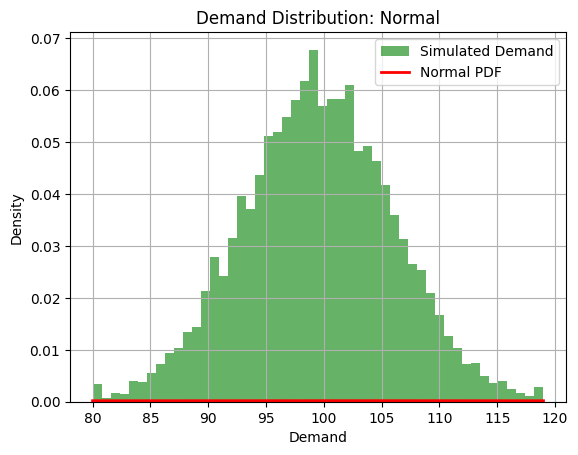

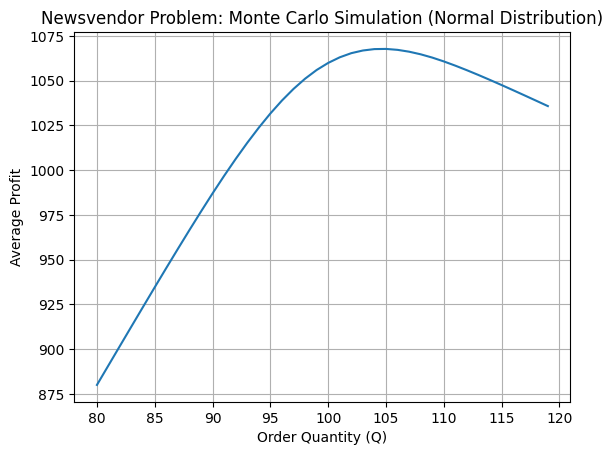

In [ ]:
# Parameters for the newsvendor problem
pp = 15  # Selling price per unit
c = 4   # Cost per unit
v = 2   # Salvage value per unit (if unsold)
h = 1   # Holding cost per unit 
order_quantities = np.arange(0, 120)

# Define general parameters for the simulation
iterations = 10000  # Number of iterations for the Monte Carlo simulation
distribution = 'normal'  # Specify the distribution to use

# Define specific parameters for each distribution
distribution_params = {
    'normal': {'mu': 100, 'sigma': 50, 'a': min(order_quantities), 'b': max(order_quantities)},
    'uniform': {'a': min(order_quantities), 'b': max(order_quantities)},
    'exponential': {'lam': 1/100, 'a': min(order_quantities), 'b': max(order_quantities)},
    'poisson': {'lam': 100, 'a': min(order_quantities), 'b': max(order_quantities)},
    'lognormal': {'mu': 4.5, 'sigma': 0.75, 'a': min(order_quantities), 'b': max(order_quantities)},
    'triangular': {'c': 100, 'a': min(order_quantities), 'b': max(order_quantities)},
    'beta': {'alpha': 2, 'beta': 5, 'a': min(order_quantities), 'b': max(order_quantities)},
    'weibull': {'lam': 100, 'k': 1.5, 'a': min(order_quantities), 'b': max(order_quantities)},
    'geometric': {'p': 0.3, 'a': min(order_quantities), 'b': max(order_quantities)},
    'negative_binomial': {'r': 10, 'p': 0.4, 'a': min(order_quantities), 'b': max(order_quantities)},
    'bernoulli': {'p': 0.5, 'a': min(order_quantities), 'b': max(order_quantities)},
    'binomial': {'n': 100, 'p': 0.3, 'a': min(order_quantities), 'b': max(order_quantities)}
}

# Initialize the LCG with a seed
lcg = LCG(seed=1234)

# Simulate demand based on the specified distribution and parameters
demands = simulate_demand(lcg, iterations, distribution, **distribution_params[distribution])

# Plot the simulated demand along with the theoretical distribution
plot_demand_distribution(demands, distribution, **distribution_params[distribution])

# Calculate the average profit for each order quantity
average_profits = [simulate_newsvendor(Q,pp,c,demands,v,h) for Q in order_quantities]

# Plot the newsvendor simulation results
plt.plot(order_quantities, average_profits)
plt.xlabel('Order Quantity (Q)')
plt.ylabel('Average Profit')
plt.title(f'Newsvendor Problem: Monte Carlo Simulation ({distribution.capitalize()} Distribution)')
plt.grid(True)
plt.show()

In [32]:
demands

array([100.92267486,  96.69855729,  98.24798738, ...,  98.91885825,
       109.03598378, 108.50390304])

In [33]:
optimal_quantity = order_quantities[np.argmax(average_profits)]
optimal_profit = max(average_profits)
print(f"Optimal Order Quantity: {optimal_quantity}")
print(f"Maximum Average Profit: {optimal_profit:.2f}")



Optimal Order Quantity: 105
Maximum Average Profit: 1067.79
